In [1]:
import warnings

import os
import torch
import pickle
import numpy as np
import os.path as osp
from tqdm import tqdm

from functools import reduce
import torch.nn.functional as F
import matplotlib.pyplot as plt

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.vae import BetaVAE
from src.cf_methods import Revise
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot
from src.utils import plot_perturbed_factuals_and_cf

/data/leuven/365/vsc36567/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-27 23:49:05.244436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748382545.262182  666793 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748382545.267549  666793 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748382545.282114  666793 computation_placer.cc:177] computation placer alrea

In [2]:
seed_everything()
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
repo_path = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/'
config_path = osp.join(repo_path, 'configs/revise_mnist_binary.yaml')
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\revise_mnist_binary.yaml"
config = get_config(config_path)
config.data_dir = osp.join(repo_path, config.data_dir)

In [4]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [22]:
os.makedirs(config.save_dir, exist_ok=True)
class_names = ds_builder.class_encodings
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""
ds_name = config.data.name
device = config.accelerator

### Load the classifier and VAE

In [25]:
baseline_classifier = SimpleCNNtorch(**config.classifier.args,
                                    img_size=config.data.img_size)
load_model_weights(baseline_classifier, weights_path=config.classifier.checkpoints_path, lightning_used=True)
evaluate_classification_model(baseline_classifier, test_loader, config.data.num_classes)
baseline_classifier = baseline_classifier.to(device)

Accuracy for the test dataset: 99.265%


In [7]:
vae = BetaVAE(**config.vae.args, input_size=(config.data.img_size, config.data.img_size))
load_model_weights(vae, weights_path=config.vae.checkpoints_path, lightning_used=True)

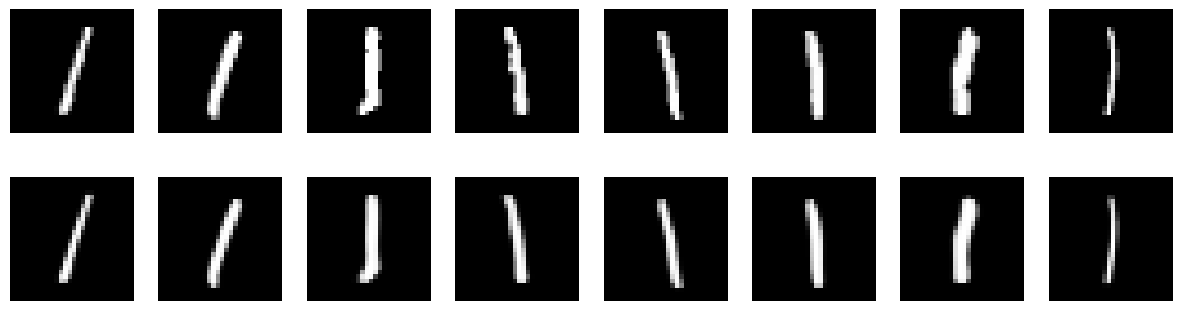

In [8]:
vae = vae.to(device)
vae.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)

    z, _ = vae.encoder(images)
    recon_images = vae.decoder(z)
    recon_images = recon_images.to(device)

    # plot reconstructed images
    _, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

### Preparing factual test instances and their perturbed versions

In [8]:
factuals, labels = extract_factual_instances(test_loader, init_class_idx=[0])
factuals, labels = filter_valid_factuals(factuals, labels, baseline_classifier)

In [9]:
# Checking for correctly predicted factuals 
preds = torch.argmax(baseline_classifier(factuals), axis=1)
print('Accuracy: {:.0%}'.format(torch.where(preds == labels)[0].shape[0] / factuals.shape[0]))

Accuracy: 100%


In [10]:
noise_magnitudes = [0.001, 0.0025, 0.005, 0.0075, 0.01]

Prepare perturbed factual instances for the generation of CFEs. We need those perturbed factuals that
are predicted correctly by the classifier

In [11]:
n = 100
factuals_pert = {}
indices_pert = {}

for noise in noise_magnitudes:
    pert_sample = perturb_sample(factuals, n_samples=1, noise_magnitude=noise)
    pert_sample = torch.Tensor(pert_sample)

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise}: ', indices.shape[0])
    factuals_pert[noise] = pert_sample
    indices_pert[noise] = indices

final_indices = reduce(np.intersect1d, list(indices_pert.values()))
factuals_pert = {k : v[final_indices][:n] for k, v in factuals_pert.items()}
factuals = factuals[final_indices][:n]
labels = labels[final_indices][:n]

Number of valid perturbed factuals for the added noise level 0.001:  1132
Number of valid perturbed factuals for the added noise level 0.0025:  1132
Number of valid perturbed factuals for the added noise level 0.005:  1132
Number of valid perturbed factuals for the added noise level 0.0075:  1132
Number of valid perturbed factuals for the added noise level 0.01:  1132


# Generate CFEs

In [48]:
target_class_ind = 1
target_class = 7

In [49]:
hparams = config.revise_hyperparameters
revise_method = Revise(baseline_classifier, vae, hparams)

In [24]:
cfes = revise_method.get_counterfactuals(factuals, verbose=False)

100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


In [25]:
fname = f'cfes_{ds_name.lower()}_{classes4fname}.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(cfes, f)

In [50]:
fname = f'cfes_{ds_name.lower()}_{classes4fname}.pkl'
with open(osp.join(config.save_dir, fname), 'rb') as f:
    cfes = pickle.load(f)

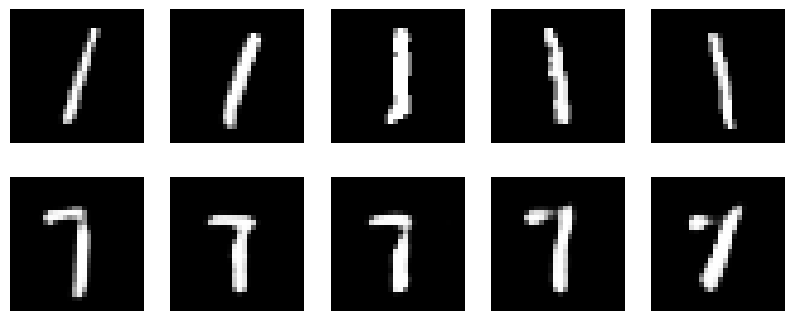

In [51]:
n_rows = 2
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        if i == 0: 
            pert_image = factuals[j].squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[j].squeeze(), cmap='gray')
            axs[i, j].axis('off')
plt.show()

In [53]:
predictions = torch.argmax(baseline_classifier(torch.Tensor(cfes).to(device)), axis=1).detach().cpu()
indices = np.where(predictions == target_class_ind)[0]
validity = indices.shape[0] / predictions.shape[0]
print(f'Validity: ',  validity)

Validity:  1.0


Read already generated CFEs

In [21]:
cfes_pert = {} 

for noise in noise_magnitudes[1:]:
    cfes_pert[noise] = revise_method.get_counterfactuals(factuals_pert[noise], verbose=False)

    fname = f'cfes_{ds_name.lower()}_{classes4fname}_noise_{noise}.pkl'
    with open(osp.join(config.save_dir, fname), 'wb') as f:
        pickle.dump(cfes_pert[noise], f)

100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


Read already generated perturbed CFEs

In [54]:
cfes_pert = {} 

for noise in noise_magnitudes:
    fname = f'cfes_{ds_name.lower()}_{classes4fname}_noise_{noise}.pkl'
    with open(osp.join(config.save_dir, fname), 'rb') as f:
        cfes_pert[noise] = pickle.load(f)

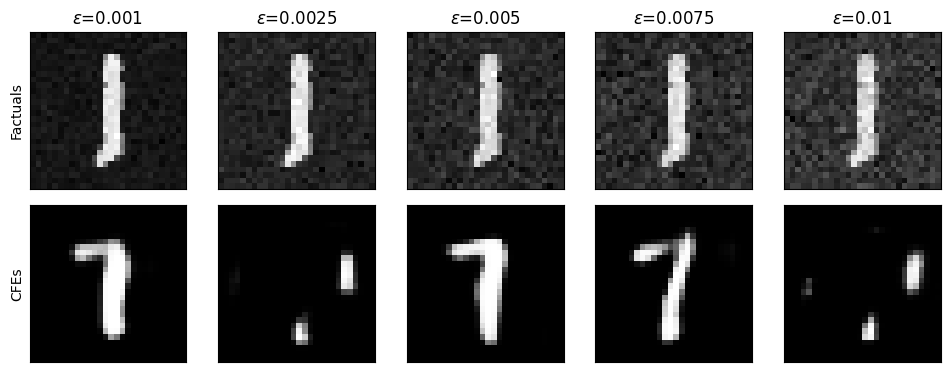

In [19]:
n_rows = 2
n_cols = 5

ind = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4), sharex=True, sharey=True)
for j in range(n_cols):
    noise = noise_magnitudes[j]
    pert_image = factuals_pert[noise][ind].squeeze().squeeze() 
    axs[0, j].imshow(pert_image, cmap='gray')
    axs[0, j].set_title('$\\epsilon$='+str(noise)) 
    
    axs[1, j].imshow(cfes_pert[noise][ind].transpose(1, 2, 0), cmap='gray')
    if j == 0:
        axs[0, j].set_ylabel('Factuals')
        axs[1, j].set_ylabel('CFEs')

plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

## Local Instability

In [57]:
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim

Checking validity of explanations after perturbation

In [55]:
validity_list = []
for noise in noise_magnitudes:
    input_cfes = torch.Tensor(cfes_pert[noise]).to('cuda')
    predictions = torch.argmax(baseline_classifier(input_cfes), axis=1).detach().cpu()
    indices = np.where(predictions == target_class_ind)[0]
    validity = indices.shape[0] / predictions.shape[0]
    validity_list.append(validity)
    print(f'Validity for the added noise level {noise}: ',  validity)

fname = f'{ds_name.lower()}_{target_class}_validity.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(validity_list, f)

Validity for the added noise level 0.001:  1.0
Validity for the added noise level 0.0025:  1.0
Validity for the added noise level 0.005:  1.0
Validity for the added noise level 0.0075:  1.0
Validity for the added noise level 0.01:  1.0


In [58]:
instability_l1_list = []
ssim_list = []

for noise, cfe_pert_list in cfes_pert.items():
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i]
        cf_pert = cfe_pert_list[i]

        if len(cf) != 0 and len(cf_pert) != 0:

            cf_tensor = torch.Tensor(cf)
            cf = cf_tensor.permute(1, 2, 0).flatten()

            cf_pert_tensor = torch.Tensor(cf_pert)
            cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

            l1_distance = sum(abs(cf - cf_perturbed)).item() # np.linalg.norm(cf.flatten() - cf_perturbed.flatten(), ord=1)
            l1_temp.append(l1_distance)

            ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
            ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)

with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_li_l1.pkl'), 'wb') as f:
    pickle.dump(instability_l1_list, f)

with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

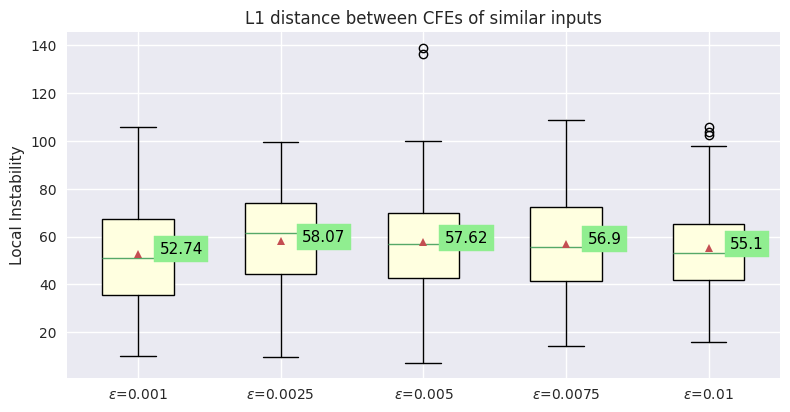

In [59]:
plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=instability_l1_list, mean_values=np.round(np.mean(instability_l1_list, axis=1), 2),
             tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
             y_label='Local Instability', colors=['lightyellow'], title='L1 distance between CFEs of similar inputs')

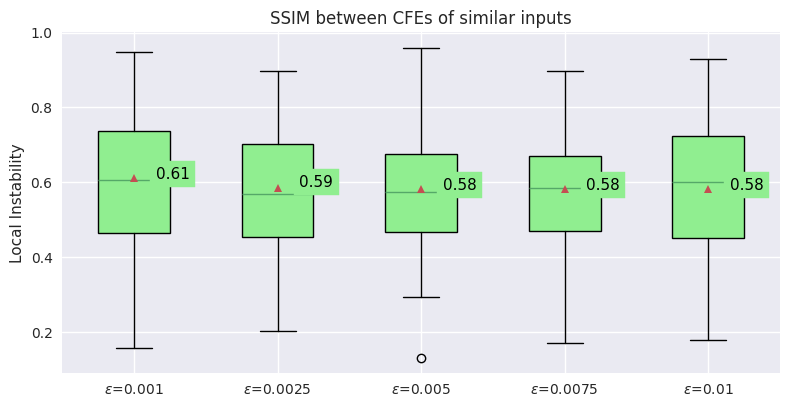

In [60]:
plot_boxplot(data=ssim_list, mean_values=np.round(np.mean(ssim_list, axis=1), 2),
             tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [47]:
original_points = factuals
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])

Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [48]:
noise_magnitude = 0.001
n_samples = 30
revise_method._params["max_iter"] = 700

lip_estimates = []

i = 0
for original_point, original_cfe in tqdm(zip(original_points[:n_samples], original_cfes[:n_samples])):

    neighbor_points = perturb_sample(original_point.unsqueeze(0), 
                                     n_samples=30, 
                                     noise_magnitude=noise_magnitude)    
    neighbor_points = torch.Tensor(neighbor_points)
    neighbor_cfes = revise_method.get_counterfactuals(neighbor_points, verbose=False)

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        if not isinstance(m, list):
            num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
            denom = np.linalg.norm((original_point - p).flatten(), ord=2)
            lip = num / denom
            lip_estimate = max(lip, lip_estimate)

    lip_estimates.append(lip_estimate)
    i += 1

100%|██████████| 30/30 [01:10<00:00,  2.36s/it]
30it [00:00, 22667.83it/s]
100%|██████████| 30/30 [01:10<00:00,  2.35s/it]
30it [00:00, 25261.82it/s]
100%|██████████| 30/30 [01:10<00:00,  2.36s/it]
30it [00:00, 6593.44it/s]
100%|██████████| 30/30 [01:10<00:00,  2.34s/it]
30it [00:00, 23750.31it/s]
100%|██████████| 30/30 [01:10<00:00,  2.34s/it]
30it [00:00, 10961.68it/s]
100%|██████████| 30/30 [01:10<00:00,  2.35s/it]
30it [00:00, 23949.20it/s]
100%|██████████| 30/30 [01:10<00:00,  2.34s/it]
30it [00:00, 12893.65it/s]
100%|██████████| 30/30 [01:10<00:00,  2.33s/it]
30it [00:00, 27600.16it/s]
100%|██████████| 30/30 [01:10<00:00,  2.35s/it]
30it [00:00, 23117.60it/s]
100%|██████████| 30/30 [01:10<00:00,  2.33s/it]
30it [00:00, 23826.76it/s]
100%|██████████| 30/30 [01:10<00:00,  2.35s/it]
30it [00:00, 26817.80it/s]
100%|██████████| 30/30 [01:10<00:00,  2.34s/it]
30it [00:00, 23643.20it/s]
100%|██████████| 30/30 [01:09<00:00,  2.33s/it]
30it [00:00, 27838.30it/s]
100%|██████████| 30/30 [01

KeyboardInterrupt: 

In [50]:
with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_lle.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

## Invalidation Rate

In [23]:
classifiers_weights_dir = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/mnist_classification/binary/checkpoints/mc_1_7"
# r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\mnist_classification\binary\checkpoints\mc_1_7'

classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**config.classifier.args,
                                    img_size=config.data.img_size)
    load_model_weights(model=cnn_perturbed, 
                        weights_path=osp.join(classifiers_weights_dir, clf_weights),
                        lightning_used=True)
    classifiers_list.append(cnn_perturbed)
    evaluate_classification_model(cnn_perturbed, 
                                dataloader=test_loader, 
                                num_classes=config.data.num_classes)

Accuracy for the test dataset: 99.632%
Accuracy for the test dataset: 99.173%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.403%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.540%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.494%
Accuracy for the test dataset: 99.586%
Accuracy for the test dataset: 99.449%


In [26]:
validity_list = []
invalidation_rate_list = []

for i, classifier in enumerate(classifiers_list):
    classifier = classifier.to(device)
    
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    for cfe in cfes:
        if isinstance(cfe, list):
            continue
        
        cfe = torch.Tensor(cfe).unsqueeze(0).to(device)
        classifier.eval()
        with torch.no_grad():
            baseline_pred = torch.argmax(baseline_classifier(cfe), axis=1)
            alternative_pred = torch.argmax(classifier(cfe), axis=1)
        total_found_cfs += 1

        if baseline_pred != alternative_pred:
            invalidation_rate += 1

        if alternative_pred == target_class_ind:
                validity += 1

    invalidation_rate /= total_found_cfs
    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity / total_found_cfs)
    print(f'Model {i}: IR={invalidation_rate}, validity={validity}')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.18, validity=82
Model 1: IR=0.11, validity=89
Model 2: IR=0.05, validity=95
Model 3: IR=0.27, validity=73
Model 4: IR=0.04, validity=96
Model 5: IR=0.19, validity=81
Model 6: IR=0.01, validity=99
Model 7: IR=0.04, validity=96
Model 8: IR=0.18, validity=82
Model 9: IR=0.17, validity=83
Average IR : 0.124 +- 0.082
Average VaR : 0.876 +- 0.082


## Relaxed Stability

In [28]:
k = 1000
sigma = 0.001

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:
        if isinstance(cfe, list):
            continue

        cfe = torch.Tensor(cfe).unsqueeze(0)
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class_ind]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class_ind]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print('Stability of the model {}: {:.3f} +- {:.3f}'.format(i, avg_i_stability.item(), np.std(stability_list).item()))
    average_stability_list.append(avg_i_stability)

Stability of the model 0: 0.866 +- 0.266
Stability of the model 1: 0.820 +- 0.191
Stability of the model 2: 0.842 +- 0.174
Stability of the model 3: 0.670 +- 0.283
Stability of the model 4: 0.912 +- 0.168
Stability of the model 5: 0.802 +- 0.335
Stability of the model 6: 0.960 +- 0.068
Stability of the model 7: 0.939 +- 0.154
Stability of the model 8: 0.857 +- 0.272
Stability of the model 9: 0.797 +- 0.245


In [29]:
print('Average RS: {:.3f} +- {:.3f}'.format(np.mean(average_stability_list), np.std(average_stability_list)))

Average RS: 0.846 +- 0.079


## LOF

In [30]:
from src.evaluation.lof import estimate_anom_cfe_in_target_class

In [34]:
try: 
    cfes_array = np.stack(cfes, axis=0)
except Exception as e:
    print(e)

In [39]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from torch.utils.data import DataLoader
from typing import Union, List

from src.utils import extract_factual_instances


def estimate_anom_cfe_in_target_class(n_neighbors: int, target_class_ind: List[int], threshold: int,
                                    test_dataloader: DataLoader, cfes: np.ndarray):
    """ Estimates how anomaluous the generated CFEs comparing to the target class distribution
    Args: 
        n_neighbors (int): a number of neighbors around the given point to consider it an inlier
        target_class_ind (List[int]): a target class index to extract the corresponding factual instances
        threshold (int): a threshold to filter out anomaluous points
        test_loader (torch.data.utils.DataLoader): a dataloader for factuals extraction
        cfes (numpy.ndarray): counterfactual explanations
    Returns: 
        (anomaly_scores, anomaly_classes) (tuple(ndarray, ndarray)): scores and classes that label each point as 
        an outlier with -1 or an inlier with 1
        """

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True, p=1)
    factuals, labels = extract_factual_instances(test_dataloader, init_class_idx=target_class_ind) 
    factuals_array = factuals.view(factuals.shape[0], -1).numpy()
    lof.fit(factuals_array)

    cfes_array = cfes.reshape(cfes.shape[0], -1)
    anomaly_scores = lof.score_samples(cfes_array)
    anomaly_classes = np.where(anomaly_scores < -1.2, -1, 1)

    return (anomaly_scores, anomaly_classes) 

In [43]:
target_class_ascores, target_class_aclasses = estimate_anom_cfe_in_target_class(5, [1], -1.1, test_loader, cfes_array)
print('LOF score wrt the target class distribution')
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(target_class_ascores), np.std(target_class_ascores)))

LOF score wrt the target class distribution
Average negative LOF (the lower values the more anomaluous): -1.225 +- 0.130


In [44]:
anomaly_scores, anomaly_classes = estimate_anom_cfe_in_target_class(5, [0, 1], -1.1, test_loader, cfes_array)
print('LOF score wrt the test set distribution')
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(anomaly_scores), np.std(anomaly_scores)))

LOF score wrt the test set distribution
Average negative LOF (the lower values the more anomaluous): -2.083 +- 0.414


In [46]:
with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_ir_var_rs.pkl'), 'wb') as f:
    pickle.dump({'ir': (np.mean(invalidation_rate_list), np.std(invalidation_rate_list)),
                'var': (np.mean(validity_list), np.std(validity_list)),
                'rs': (np.mean(average_stability_list), np.std(average_stability_list)),
                'lof_target_class': (np.mean(target_class_ascores), np.std(target_class_ascores)),
                'loc_test_set': (np.mean(anomaly_scores), np.std(anomaly_scores))
                }, f)